In [5]:
import pandas as pd
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, log_loss
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("../data/submissions.csv")
eviction_df = df[df["outcome"] == "eviction"]
eviction_df = eviction_df[eviction_df["truth"].notna()]
eviction_df = eviction_df[(eviction_df["prediction"] <= 1) & (eviction_df["prediction"] >= 0)] # four models have invalid predictions (>1 or < 0 outputs)

In [16]:
# Define a function to calculate error metrics for each model
def compute_error_metrics(group):
    brier_score = brier_score_loss(group['truth'], group['prediction'])
    logloss = log_loss(group['truth'], group['prediction'])
    return pd.Series({'brier_score': brier_score, 'log_loss': logloss})

# Compute error metrics for each model
error_metrics = eviction_df.groupby('account').apply(compute_error_metrics)

# Select top N models based on Brier score (or log_loss)
top_models = error_metrics.nsmallest(10, 'log_loss').index


# Function to calculate custom calibration curve
def custom_calibration_curve(df, bins):
    temp_df = df.copy()
    temp_df.loc[:, 'bin'] = pd.cut(temp_df['prediction'], bins=bins, right=False, include_lowest=True)
    
    grouped = temp_df.groupby('bin')
    calibration_data = grouped.agg(
        prob_pred=('prediction', 'mean'),
        frac_positives=('truth', 'mean'),
        count=('prediction', 'size')  # count the number of entries in each bin
    ).reset_index()
    
    return calibration_data


Model mb298:
           bin  count
0  [0.0, 0.05)   1240
1  [0.05, 1.0)   5110
Model NaijiaLiu:
           bin  count
0  [0.0, 0.05)    945
1  [0.05, 1.0)   5406
Model hamidrezaomidvar:
           bin  count
0  [0.0, 0.05)    945
1  [0.05, 1.0)   5406
Model Justajwu:
           bin  count
0  [0.0, 0.05)   1449
1  [0.05, 1.0)   4915
Model dremalt:
           bin  count
0  [0.0, 0.05)   1451
1  [0.05, 1.0)   4913
Model amaatouq:
           bin  count
0  [0.0, 0.05)   1505
1  [0.05, 1.0)   4859
Model malte:
           bin  count
0  [0.0, 0.05)   1404
1  [0.05, 1.0)   4960
Model lbb285:
           bin  count
0  [0.0, 0.05)    981
1  [0.05, 1.0)   5383
Model kgenova:
           bin  count
0  [0.0, 0.05)    684
1  [0.05, 1.0)   5669
Model spike_slab_team:
           bin  count
0  [0.0, 0.05)   1015
1  [0.05, 1.0)   2167


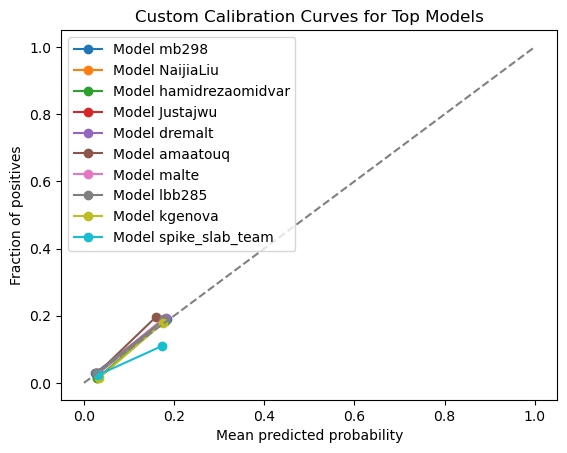

In [19]:
bins = [0, 0.05, 1]
# Plot calibration curves for top models
fig, ax = plt.subplots()

for model in top_models:
    model_data = df[df['account'] == model]
    calibration_data = custom_calibration_curve(model_data, bins)
    ax.plot(calibration_data['prob_pred'], calibration_data['frac_positives'], marker='o', label=f'Model {model}')
    print(f"Model {model}:")
    print(calibration_data[['bin', 'count']])  # Print the count of predictions per bin for each model
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_xlabel('Mean predicted probability')
ax.set_ylabel('Fraction of positives')
ax.set_title('Custom Calibration Curves for Top Models')
ax.legend()

plt.show()